<a href="https://colab.research.google.com/github/BillWang04/CSE151A-Group-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
business = pd.read_csv('data/business.csv')
economy = pd.read_csv('data/economy.csv')

In [3]:
def clean(df, class_):
    def extract_stops(description):
        stops_match = re.search(r'(\d+)-?stop', description)
        if stops_match:
            return int(stops_match.group(1))
        else:
            return 0
    def duration_to_hours(duration):
        hours, minutes = duration.split('h ')
        hours = float(hours.strip()) if len(hours.strip()) > 1 else 0
        minutes = int(minutes[:-1].strip()) if len(minutes.strip()) > 1 else 0
        total_hours = hours + minutes / 60
        return round(total_hours, 3)
    df_copy = df.copy()
    df_copy["price"] = df_copy["price"].str.replace("," , "").astype(int)
    df_copy["flight_code"] = df_copy["ch_code"].astype(str).str.cat(df_copy["num_code"].astype(str), sep="_")
    df_copy['num_stops'] = df_copy['stop'].apply(extract_stops)
    df_copy["time_taken"] = df_copy["time_taken"].apply(duration_to_hours)
    df_copy['date'] = pd.to_datetime(df_copy['date'], format="%d-%m-%Y")
    df_copy['day_of_week'] = df_copy['date'].dt.dayofweek
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
    df_copy['arr_time'] = df_copy['arr_time'].dt.hour + (df_copy['arr_time'].dt.minute >= 30)
    df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
    df_copy['dep_time'] = df_copy['dep_time'].dt.hour + (df_copy['dep_time'].dt.minute >= 30)
    df_copy = df_copy.drop(columns= ["date", "ch_code", "num_code", "stop"])
    df_copy["class"] = class_
    df_copy = df_copy[["airline", "flight_code", "class", "from", "to", "time_taken", "dep_time", "arr_time", "num_stops", "month", "day_of_week", "price"]]
    return df_copy



In [4]:
cleaned_df = pd.concat([clean(economy, "economy"), clean(business, "business")])
cleaned_df

/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_81266/2232736731.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_81266/2232736731.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
/var/folders/80/vdccj0dj1cs241gycwjdbz580000gn/T/ipykernel_81266/2232736731.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/80/vdc

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


In [5]:
# drop the qualitative data
quantidata = cleaned_df.drop(columns = ['airline','flight_code','class','from','to'])

# **Preprocess the data**

In [12]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# quantidata is just numerical data
#One Hot Encode (Y)
oneHot = OneHotEncoder()
oneHot_classes = oneHot.fit_transform(cleaned_df.airline.values.reshape(-1,1)).toarray()
y = oneHot_classes

#Normalize the data
#classed_dropped = cleaned_df.drop(columns= ['class', 'airline', 'flight_code', 'from', 'to'])

norm_scaler = MinMaxScaler()
normalized_data = norm_scaler.fit_transform(quantidata)

#Standardize the data
stand_scaler = StandardScaler()
standardized_data = stand_scaler.fit_transform(quantidata)

## Modeling

### Linear Regression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

cleaned_df['weekend'] = cleaned_df['day_of_week'] > 4

X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['price']), cleaned_df['price'], test_size=0.2, random_state=66)


prepoc = ColumnTransformer([
    ('airline', OneHotEncoder(handle_unknown='ignore'), ['airline', 'class']), #comment out for baseline
    ('log', FunctionTransformer(lambda x: np.log(x + 0.001)), ['time_taken']), # comment out for baseline
    # ('square', FunctionTransformer(lambda x: x**2), ['RES.PRICE']),
    ('test', FunctionTransformer(lambda x: x), ['dep_time', 'arr_time', 'num_stops', 'weekend']),
    # ('test', FunctionTransformer(lambda x: x), ['TOTAL.PRICE', 'OUTAGE.DURATION']), #baseline
], remainder='drop')

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', LinearRegression())
    ])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# # Predict on the testing data
predictions = pipe.predict(X_test)



In [ ]:
train_predictions = pipe.predict(X_train)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
/Users/kailey/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


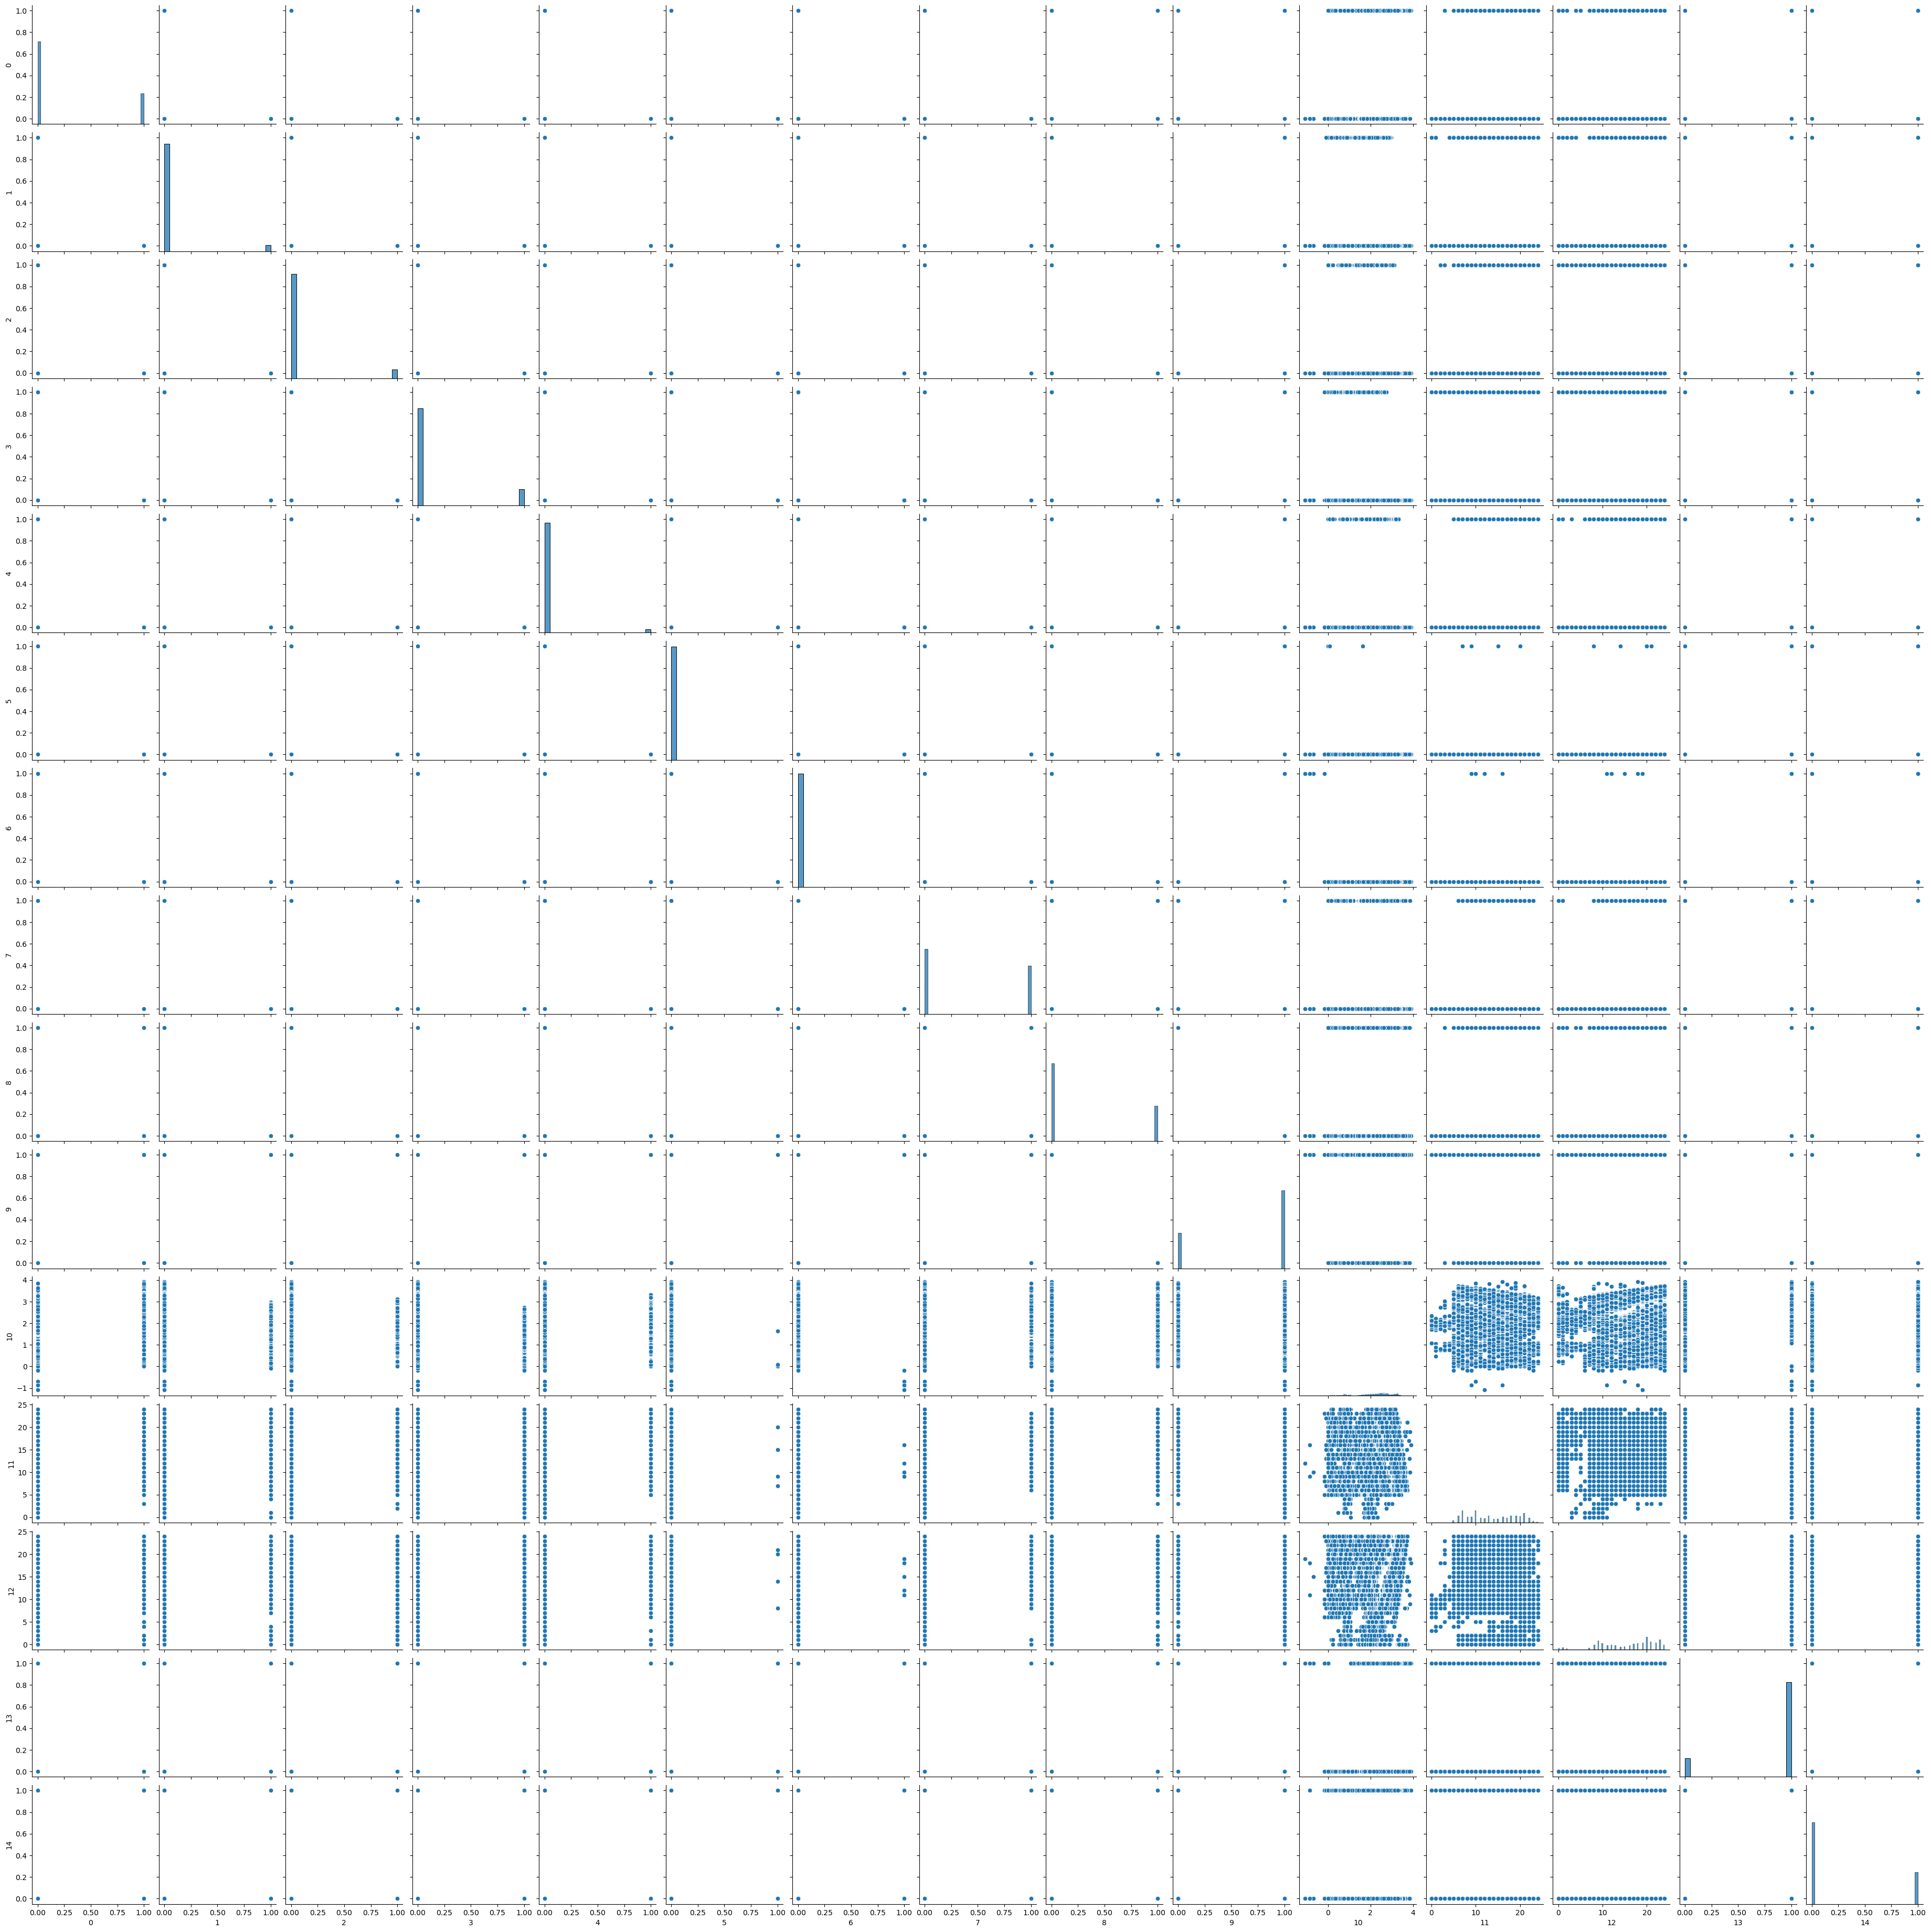

In [52]:
from sklearn import set_config

set_config(display='text')


# Create a DataFrame with the transformed features
transformed_features = prepoc.transform(cleaned_df.drop(columns=['price']))

# Convert the transformed features to a DataFrame
transformed_df = pd.DataFrame(transformed_features)

# Visualize the transformed features
sns.pairplot(transformed_df)
plt.show()


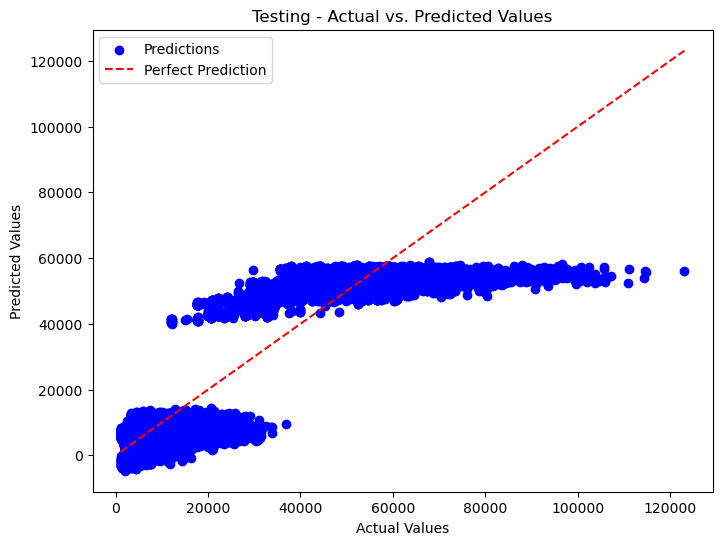

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Testing - Actual vs. Predicted Values')
plt.legend()
plt.show()

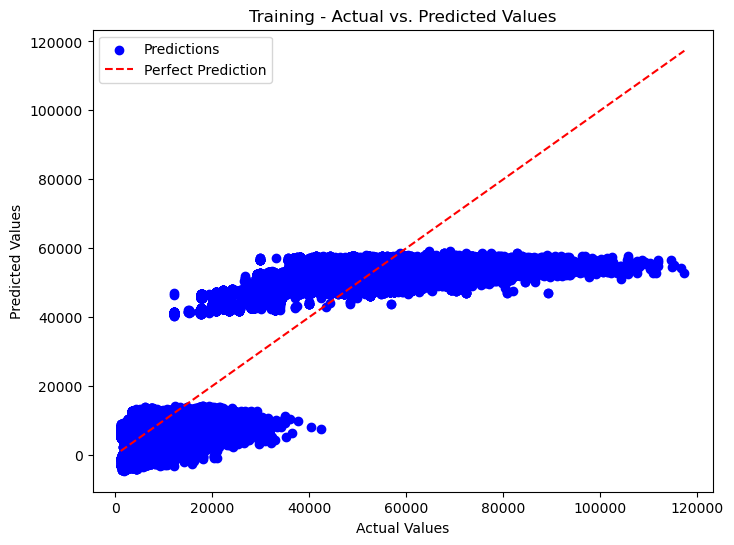

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, train_predictions, color='blue', label='Predictions')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training - Actual vs. Predicted Values')
plt.legend()
plt.show()

In [50]:
cleaned_df.drop(columns=['price']).columns

Index(['airline', 'flight_code', 'class', 'from', 'to', 'time_taken',
       'dep_time', 'arr_time', 'num_stops', 'month', 'day_of_week', 'weekend'],
      dtype='object')

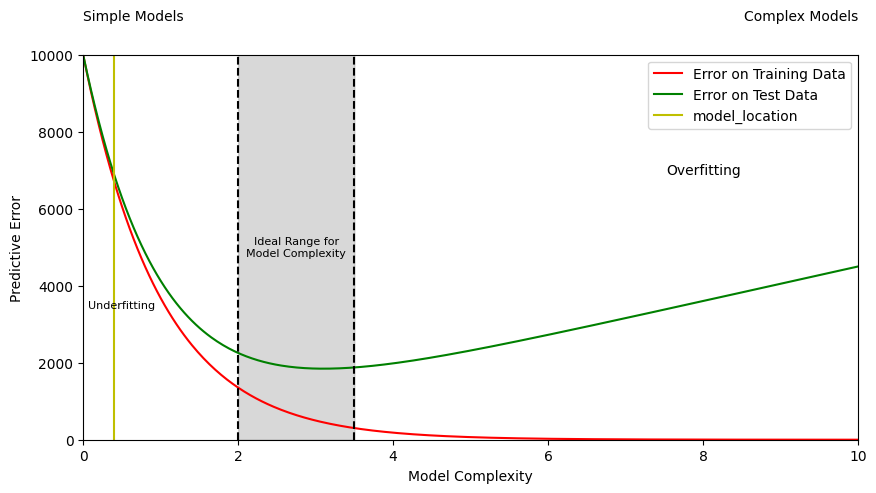

In [34]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(8, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()


#### Random Forest Regression


In [14]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
prepoc = ColumnTransformer([
    ('airline', OneHotEncoder(handle_unknown='ignore'), ['airline', 'class']), #One Hot Encoding airline and class
    ('log', FunctionTransformer(lambda x: np.log(x + 0.001)), ['time_taken']), # Loging Time Taken 
    ('test', FunctionTransformer(lambda x: x), ['dep_time', 'arr_time', 'num_stops', 'weekend']), # Keeping all of the values 
], remainder='drop')

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', RandomForestRegressor())
    ])

pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

In [37]:
train_predictions = pipe.predict(X_train)

RMSE_test = np.sqrt(np.sum((y_test - predictions)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - train_predictions)**2) / y_train.shape[0])
print(f'RMSE Test: { RMSE_test }')
print(f'RMSE Train: { RMSE_train }')

RMSE Test: 4126.950091324907
RMSE Train: 3768.614335146322


In [1]:
from sklearn import tree

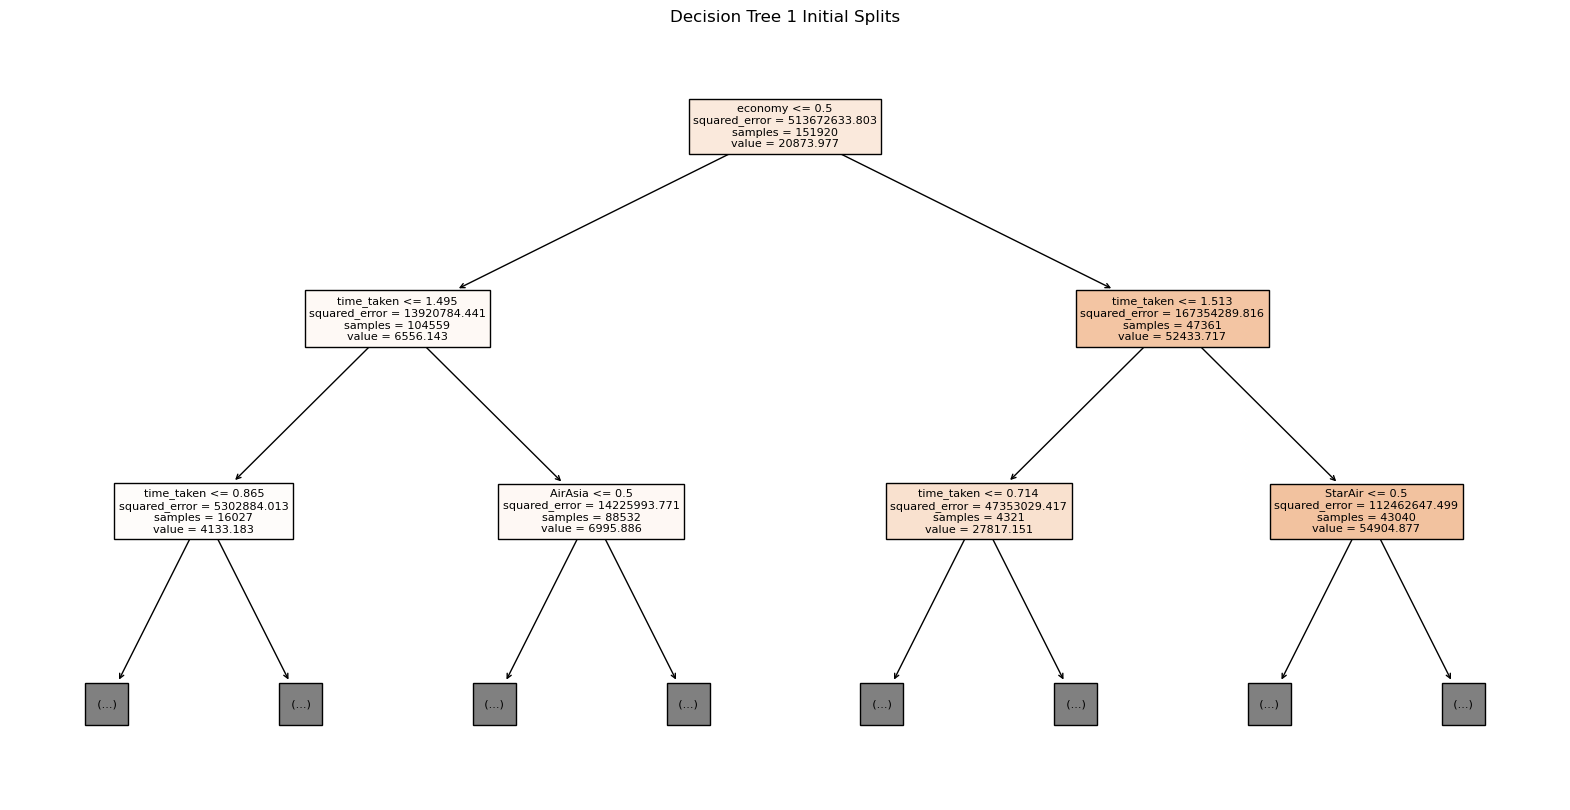

In [87]:
random_forest_model = pipe.named_steps['pog'].estimators_[0]  # Extracting one of the trees from the RandomForestRegressor

feature_names = ['SpiceJet', 'AirAsia', 'Vistara', 'GO FIRST', 'Indigo',
       'Air India', 'Trujet', 'StarAir', 'economy', 'business', 'time_taken', 'dep_time', 'arr_time', 'num_stops', 'weekend']

plt.figure(figsize=(20, 10))
tree.plot_tree(random_forest_model, feature_names=feature_names, max_depth=2, filled=True)
plt.title('Decision Tree 1 Initial Splits')
plt.show()

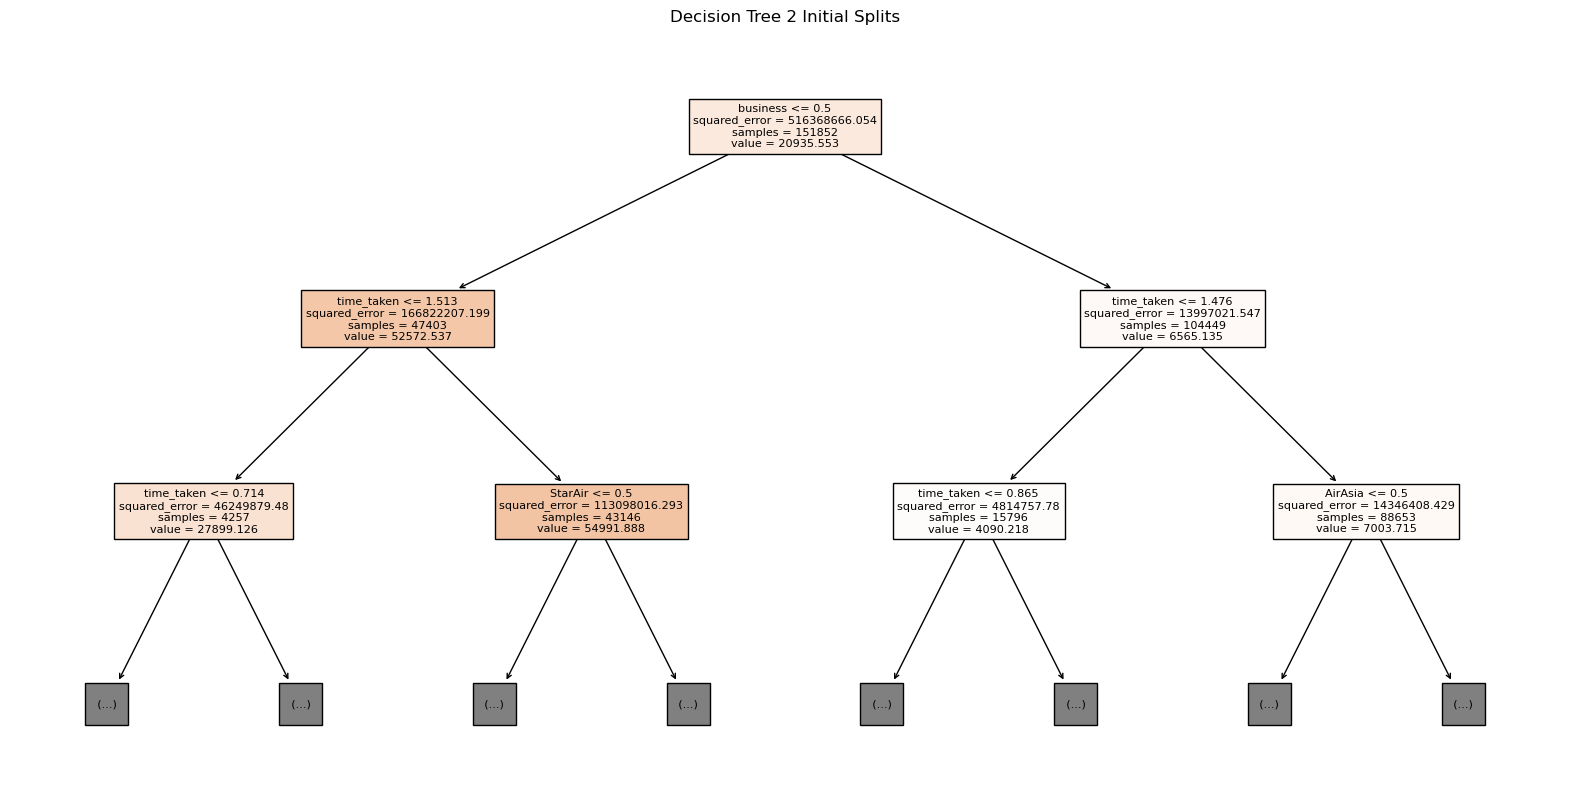

In [96]:
random_forest_model = pipe.named_steps['pog'].estimators_[1]  # Extracting one of the trees from the RandomForestRegressor

feature_names = ['SpiceJet', 'AirAsia', 'Vistara', 'GO FIRST', 'Indigo', 'Air India', 'Trujet', 'StarAir', 'economy', 'business', 'time_taken', 'dep_time', 'arr_time', 'num_stops', 'weekend']

plt.figure(figsize=(20, 10))
tree.plot_tree(random_forest_model, feature_names=feature_names, max_depth=2, filled=True)
plt.title('Decision Tree 2 Initial Splits')
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


# params = {
#     'pog__n_estimators': [50, 75, 100, 125, 150, 200, 250, 300], 
#     'pog__max_features': [1, 3, 5, 7, 9, 12, 15, 18, 20], 
#     'pog__min_samples_split': [2, 5, 8, 10, 12, 15]
# }

# grid_search = RandomizedSearchCV(estimator=pipe, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)

param_dist = {
    'pog__n_estimators': randint(50, 300),
    'pog__max_features': randint(1, 20),
    'pog__min_samples_split': randint(2, 15)
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10, 
    cv=5,     
    scoring='neg_mean_squared_error',  
    verbose=1,
    n_jobs=-1,
    random_state=66   
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ahmostafa/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ahmostafa/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ahmostafa/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/ahmostafa/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/ensemble/_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prepoc',
                                              ColumnTransformer(transformers=[('airline',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['airline',
                                                                                'class']),
                                                                              ('log',
                                                                               FunctionTransformer(func=<function <lambda> at 0x2c0153280>),
                                                                               ['time_taken']),
                                                                              ('test',
                                                                               FunctionTransformer(func=<function <lam

In [39]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prepoc', 'pog', 'prepoc__n_jobs', 'prepoc__remainder', 'prepoc__sparse_threshold', 'prepoc__transformer_weights', 'prepoc__transformers', 'prepoc__verbose', 'prepoc__verbose_feature_names_out', 'prepoc__airline', 'prepoc__log', 'prepoc__test', 'prepoc__airline__categories', 'prepoc__airline__drop', 'prepoc__airline__dtype', 'prepoc__airline__handle_unknown', 'prepoc__airline__sparse', 'prepoc__log__accept_sparse', 'prepoc__log__check_inverse', 'prepoc__log__func', 'prepoc__log__inv_kw_args', 'prepoc__log__inverse_func', 'prepoc__log__kw_args', 'prepoc__log__validate', 'prepoc__test__accept_sparse', 'prepoc__test__check_inverse', 'prepoc__test__func', 'prepoc__test__inv_kw_args', 'prepoc__test__inverse_func', 'prepoc__test__kw_args', 'prepoc__test__validate', 'pog__bootstrap', 'pog__ccp_alpha', 'pog__criterion', 'pog__max_depth', 'pog__max_features', 'pog__max_leaf_nodes', 'pog__max_samples', 'pog__min_impurity_decrease', 'pog__min_samples_leaf'

In [40]:
random_search.best_params_

{'pog__max_features': 2,
 'pog__min_samples_split': 14,
 'pog__n_estimators': 249}

In [41]:
best_params = {
    'n_estimators': 249,
    'max_features': 2,
    'min_samples_split': 14
}

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', RandomForestRegressor(**best_params))
    ])

pipe.fit(X_train, y_train)

# # Predict on the testing data
predictions = pipe.predict(X_test)

In [ ]:
train_predictions = pipe.predict(X_train)

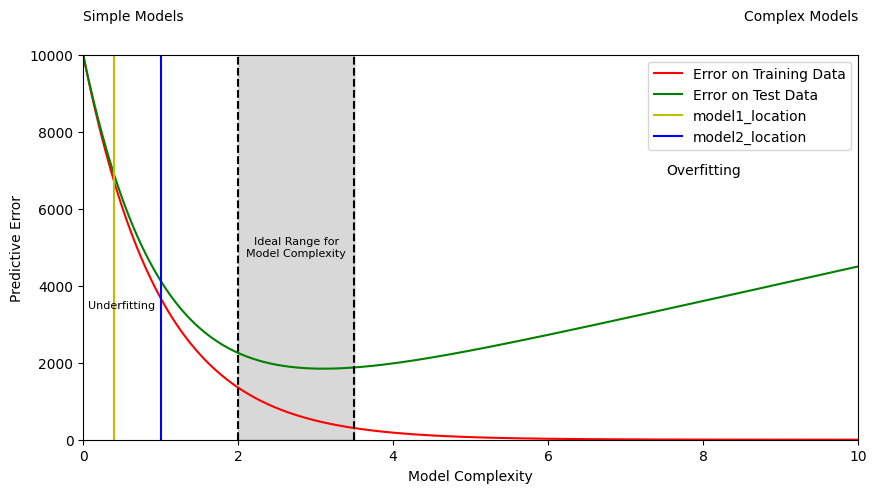

In [47]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model1_location")
plt.axvline(x=1.0, color='b', label="model2_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(8, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()

In [18]:
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from scipy.stats import randint
pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', XGBRegressor(n_estimators=150, learning_rate=0.08, max_depth=20, random_state = 22))
    ])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)


RMSE_test = np.sqrt(np.sum((y_test - y_pred)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - pipe.predict(X_train))**2) / y_train.shape[0])
print(RMSE_train)
print("Mean Squared Error:", RMSE_test)

3873.6988212916344
Mean Squared Error: 4225.379033266992


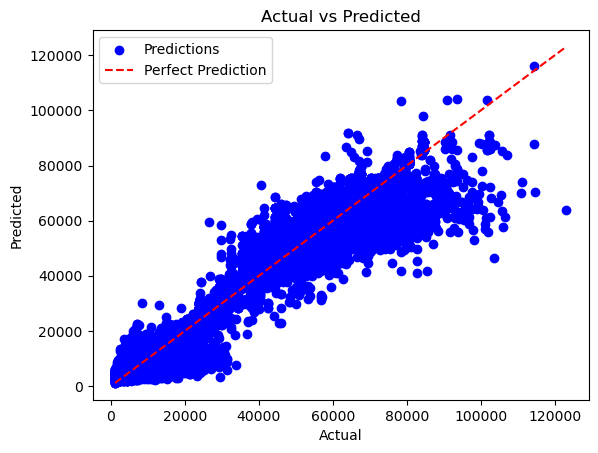

In [34]:
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

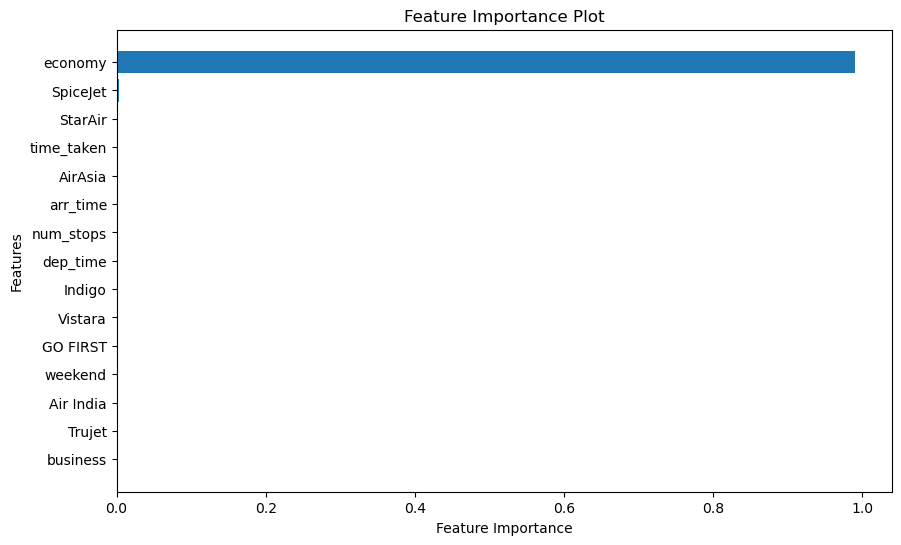

In [60]:
feature_names = ['SpiceJet', 'AirAsia', 'Vistara', 'GO FIRST', 'Indigo', 'Air India', 'Trujet', 'StarAir', 'economy', 'business', 'time_taken', 'dep_time', 'arr_time', 'num_stops', 'weekend']

plt.figure(figsize=(10, 6))
importance = pipe.named_steps['pog'].feature_importances_
sorted_idx = np.argsort(importance)
plt.barh(range(15), importance[sorted_idx], align='center')
plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

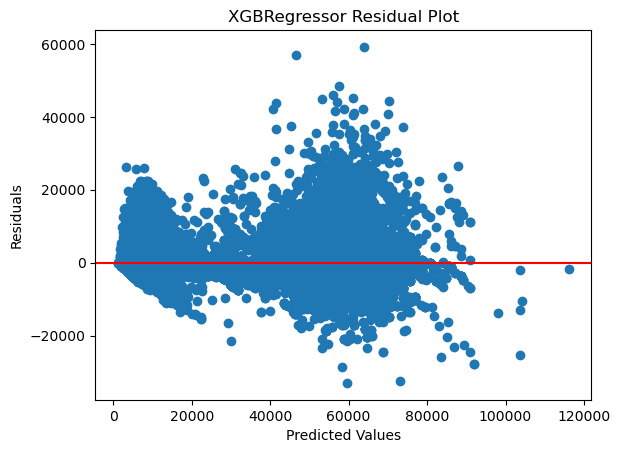

In [62]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0 for reference
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBRegressor Residual Plot")
plt.show()

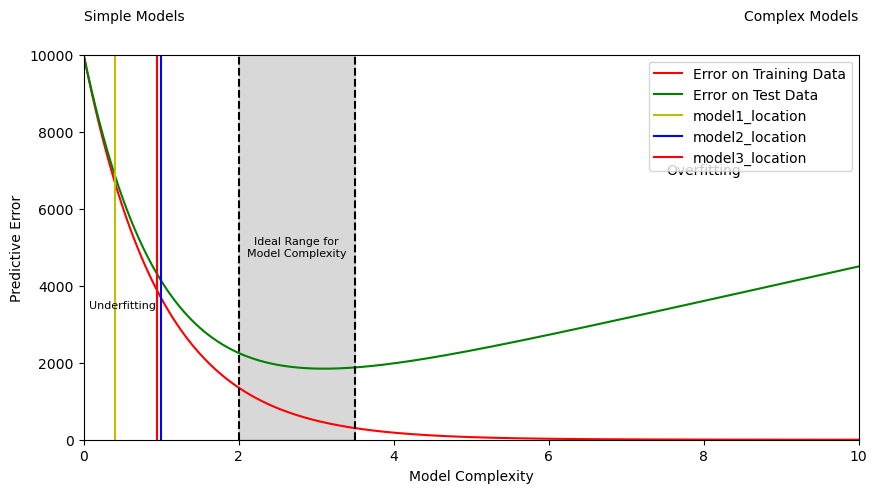

In [39]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model1_location")
plt.axvline(x=1.0, color='b', label="model2_location")
plt.axvline(x=0.95, color='r', label="model3_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(8, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()